In [2]:
import pandas as pd
import os, gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [10]:
useID = False

class DataLoader():
    def __init__(self, transaction=True):
        self._data_path = "../../data/"
        self._transaction = transaction

    @property
    def transaction(self):
        return self._transaction
    @transaction.setter
    def transaction(self, value):
        self._transaction = value
    
    def add_transaction_features(self, df):
        df["TransactionDay"] = df["TransactionDT"] / (24*60*60)
        d_columns = [f'D{i}' for i in range(1, 16)]
        for i, col in enumerate(d_columns):
            df[col] = df["TransactionDay"] - df[col]

        for i in range(1,10):
            df["M"+str(i)] = df["M"+str(i)].astype(bool)
        # Deal with categorical features
        # trees don't care about cardinality, we can transform them all into integer codes. Some such as addr1 are already numbers
        #categorical_vars = ["ProductCD", "card1","card2","card3","card4","card5","card6","addr1", "addr2", "P_emaildomain", "R_emaildomain"]
        categorical_vars = ["ProductCD","card4","card6","P_emaildomain", "R_emaildomain"]
        for cat in categorical_vars:
            df[cat] = pd.factorize(df[cat])[0]
            # df[cat] =  self._label_encoder.fit_transform(df[cat])
    
        return df
    
    def reduce_mem_usage(self, df):

        for col in df.select_dtypes(include=[np.number]).columns:
            col_data = df[col]    

            if pd.api.types.is_float_dtype(col_data):
                # Downcast to float
                df[col] = pd.to_numeric(col_data, downcast='float')
            elif pd.api.types.is_integer_dtype(col_data):
                # Downcast to smaller int
                df[col] = pd.to_numeric(col_data, downcast='integer')

        df.info(memory_usage='deep')
        return df
    
    def aggregate_encoding(self, df):
        return

    def load_csv(self, file_name):
        with open(os.path.join(self._data_path, file_name)) as f:
            df = pd.read_csv(f)#, nrows=200000)

        if self._transaction:    
            self.add_transaction_features(df)
        df = self.reduce_mem_usage(df)

        return df

dl = DataLoader()
df_tr = dl.load_csv("train_transaction.csv")
df_tr_test = dl.load_csv("test_transaction.csv")

if useID:
    dl.transaction = False
    df_id = dl.load_csv("train_identity.csv")
    df_id_test = dl.load_csv("test_identity.csv")

    df_train = df_tr.merge(df_id, how='left', left_index=True, right_index=True)

    fix = {o:n for o, n in zip(df_id_test.columns, df_id.columns)}
    df_id.rename(columns=fix, inplace=True)
    df_test = df_tr_test.merge(df_id, how='left', left_index=True, right_index=True)

    del df_id, df_id_test, df_train, df_tr_test

else:
    df_train = df_tr
    df_test = df_tr_test
    del df_tr, df_tr_test

gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 395 entries, TransactionID to TransactionDay
dtypes: bool(9), float32(377), int16(1), int32(2), int8(6)
memory usage: 863.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 394 entries, TransactionID to TransactionDay
dtypes: bool(9), float32(377), int16(1), int32(2), int8(5)
memory usage: 740.3 MB


13106

In [6]:
def plot_corr(df):
    # Compute the correlation matrix
    corr_matrix = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

## Transaction Table
IP, ISP, Proxy, UA, browser, os, etc.associated with the transactions. Field names are masked for privacy

**Cateogorical features**: DeviceType, DeviceInfo, id_12-id_38

In [4]:
target_col = 'isFraud'
input_cols =  [f'D{i}' for i in range(1, 16)]


# Step 1: Compute correlation matrix for input features
corr_matrix = df_train[input_cols].corr().abs()

# Step 2: Mask upper triangle and self-correlations
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr_pairs = corr_matrix.where(upper).stack()
high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.95]

# Step 3: Determine which column in each pair to drop
to_drop = set()
for col1, col2 in high_corr_pairs.index:
    corr1 = abs(df_train[[col1, target_col]].corr().iloc[0, 1])
    corr2 = abs(df_train[[col2, target_col]].corr().iloc[0, 1])
    drop_col = col1 if corr1 < corr2 else col2
    to_drop.add(drop_col)

# Step 4: Drop selected columns
df_train = df_train.drop(columns=list(to_drop))

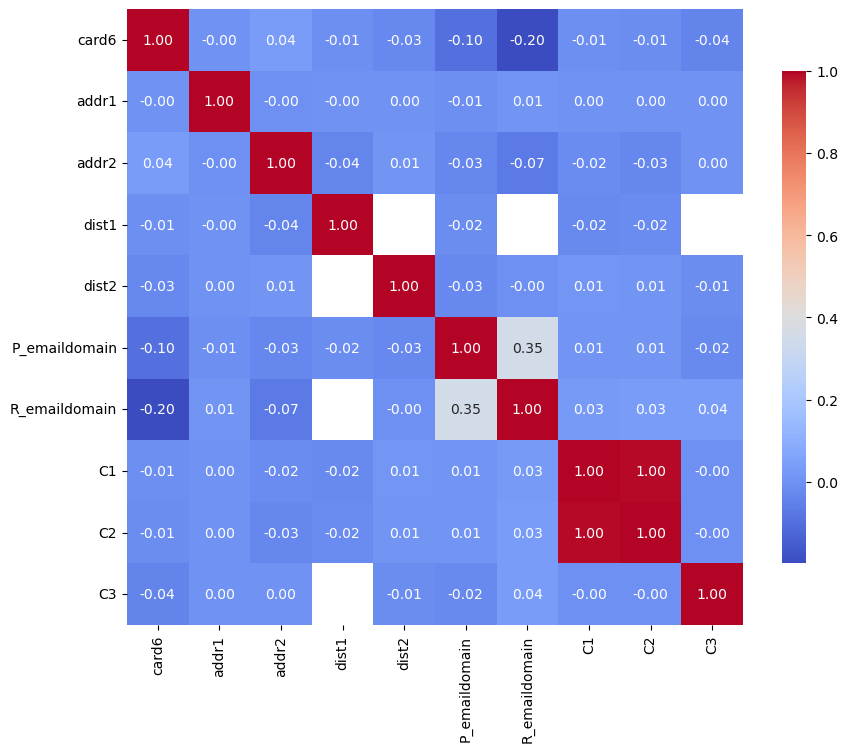

In [5]:
plot_corr(df_train.iloc[:,10:20])

In [13]:
def remove_correlated_columns(df, columns, target_col="isFraud", keep_corr=True):
    """
    df:         pandas dataframe
    column:     list of column names to consider
    target:     the column who's final correlation we are interested in
    keep_corr:  keep only the column which is most correlated with the target. If False, keep the column with the most unique values
    return:     new dataframe with columns removed if they are highly correlated. Only the column most correlated with the target is kept
    """

    # Step 1: Compute correlation matrix for input features
    corr_matrix = df[columns].corr().abs()

    # Step 2: Mask upper triangle and self-correlations
    upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    high_corr_pairs = corr_matrix.where(upper).stack()
    high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.95]

    # Step 3: Determine which column in each pair to drop
    to_drop = set()
    for col1, col2 in high_corr_pairs.index:

        if keep_corr:
            corr1 = abs(df[[col1, target_col]].corr().iloc[0, 1])
            corr2 = abs(df[[col2, target_col]].corr().iloc[0, 1])
            drop_col = col1 if corr1 < corr2 else col2
        else:
            drop_col = col1 if df[col1].nunique() >= df[col2].nunique() else col2

        to_drop.add(drop_col)

    # Step 4: Drop selected columns
    df = df.drop(columns=list(to_drop))

    return df


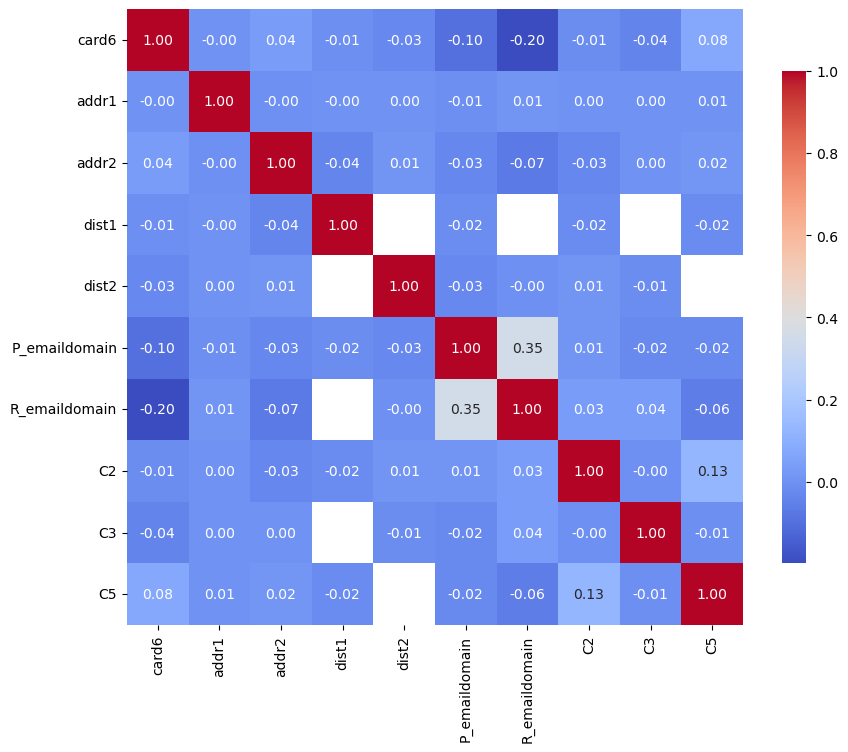

In [12]:
target_col = 'isFraud'
input_cols =  [f'C{i}' for i in range(1, 6)]
df_train = remove_correlated_columns(df_train, input_cols, target_col, False)
plot_corr(df_train.iloc[:,10:20])


In [ ]:
target_col = 'isFraud'
input_cols =  [f'V{i}' for i in range(1, 340)]



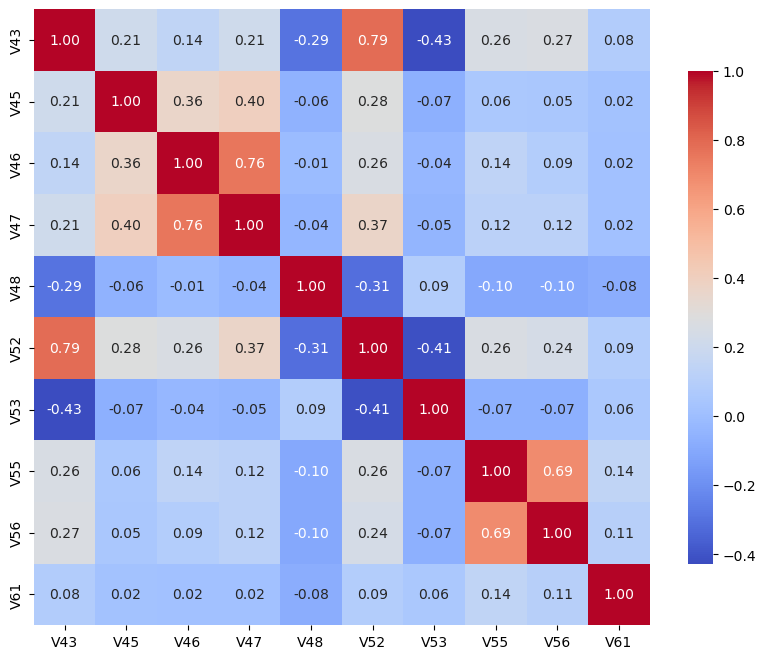

In [11]:
plot_corr(df_train.iloc[:,70:80])

In [14]:
# Look at correlation between variables which are sparsely populated
"""
Many variables are sparsley populated. And many appear to be sparsley populated in the same way.
For variables which are sparsley populated in the same way, find out which ones are correlated with each other.
Of the ones which are highly correlated, only keep the one which is most highly correlated with isFraud.
Alternatively: Only keep the one which  has the most unique values
"""
# Organize columns which are equally sparsley populated
cols = []
col_dict = {}
for col in df_train.columns:
    total_nan = int(df_train[col].isna().sum())
    percent_pop = (len(df_train) - df_train[col].isna().sum()) / len(df_train) *100 # percent of rows which are not NaN
    percent_pop = round(percent_pop, 2)
    
    if not percent_pop in col_dict.keys():
        col_dict[percent_pop] = []

    col_dict[percent_pop].append(col)
    # print( percent_pop, f" % of rows contain values for {col}")
    
vars_to_keep = []
for percent in col_dict.keys():
    if percent < 50 and len(col_dict[percent]) > 1:
        df_subset = df_train[col_dict[percent]]
        df_subset = remove_correlated_columns(df_subset, col_dict[percent], keep_corr=False)
        vars_to_keep += list(df_subset.columns)



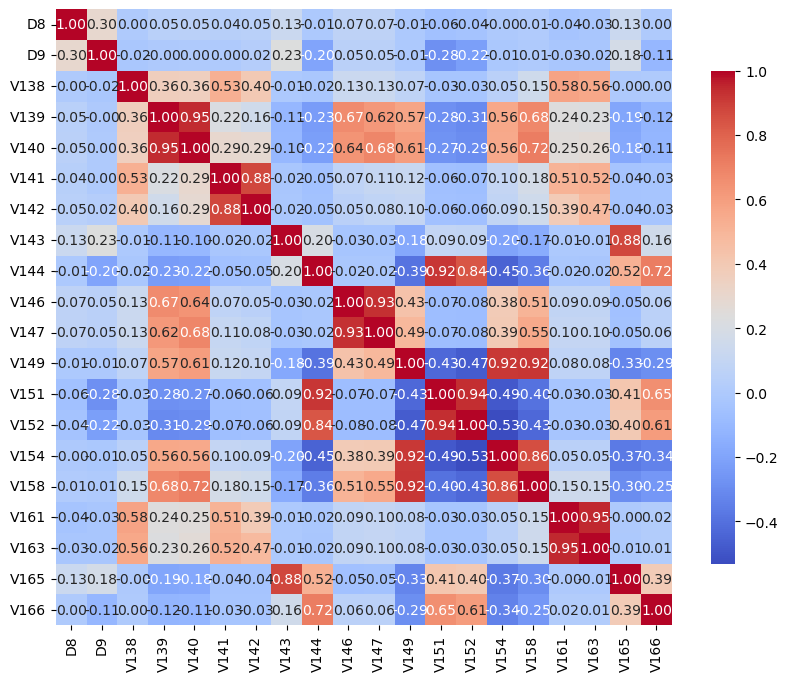

In [17]:
var = vars_to_keep[0:20]
plot_corr(df_train[var])

In [12]:
# Look at correlation between variables which are sparsely populated
"""
Many variables are sparsley populated. And many appear to be sparsley populated in the same way.
For variables which are sparsley populated in the same way, find out which ones are correlated with each other.
Of the ones which are highly correlated, only keep the one which is most highly correlated with isFraud.
Alternatively: Only keep the one which  has the most unique values
"""
# Organize columns which are equally sparsley populated
cols = []
col_dict = {}
for col in df_train.columns:
    total_nan = int(df_train[col].isna().sum())
    percent_pop = (len(df_train) - df_train[col].isna().sum()) / len(df_train) *100 # percent of rows which are not NaN
    percent_pop = round(percent_pop, 2)
    
    if not percent_pop in col_dict.keys():
        col_dict[percent_pop] = []

    col_dict[percent_pop].append(col)
    # print( percent_pop, f" % of rows contain values for {col}")
    
vars_to_keep = []
for percent in col_dict.keys():
    if percent < 50 and len(col_dict[percent]) > 1:
        corr_sparse = df_train[col_dict[percent]].corr(numeric_only=True)    

        strong_corr = corr_sparse.where((corr_sparse.abs() > 0.75) & (corr_sparse.abs() < 1.0))
        # Do we want to keep sparsley popoulated variables if they aren't correlated with other variables?
        # nan_columns = strong_corr.columns[strong_corr.isna().all()]
        # vars_to_keep += list(nan_columns)
        
        strong_corr_pairs = strong_corr.stack().reset_index()
        strong_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
        if len(strong_corr_pairs) == 0: continue
        # remove duplicate pairs
        strong_corr_pairs = strong_corr_pairs[strong_corr_pairs['Variable 1'] < strong_corr_pairs['Variable 2']]
        
        # Find variable most highly correlated with isFraud
        vars_with_strong_corr = pd.unique(
            strong_corr_pairs[['Variable 1', 'Variable 2']].values.ravel()
        )

        ## Keep the variable that is most highy correlated with isFraud
        # corr_fraud = df_train[vars_with_strong_corr].corrwith(df_train["isFraud"], numeric_only=True).abs()
        # vars_to_keep.append(corr_fraud.idxmax())

        ## Alternatively, keep the variable with the most unique values
        # vars_to_keep.append(df_train[vars_with_strong_corr].nunique().idxmax())
        
        ## Or combine the two. Take the variable with the most unique values of the variables which are correlated with isFraud above some threshold
        corr_fraud = df_train[vars_with_strong_corr].corrwith(df_train["isFraud"], numeric_only=True).abs() > 0.25 # must be 0.25 correlated
        # select only true values from mask
        corr_fraud = corr_fraud[corr_fraud].index
        # If there are no variables passing the threshold then don't use them
        if len(corr_fraud) < 1:
            continue
            
        vars_to_keep.append(df_train[corr_fraud].nunique().idxmax())
    else:
        vars_to_keep += col_dict[percent]

df_train = df_train[vars_to_keep]

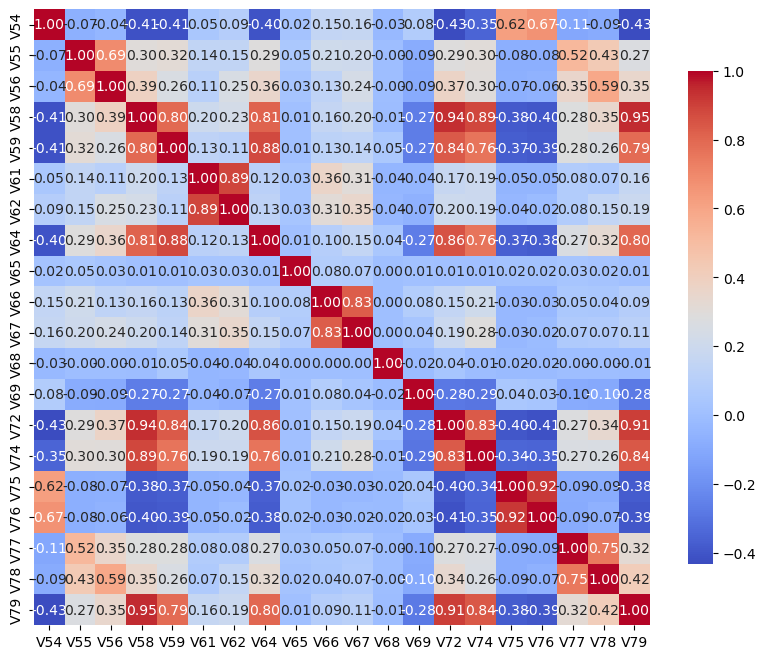

In [13]:
plot_corr(df_train.iloc[:,100:120])

In [15]:
target_col = 'isFraud'
input_cols =  [i for i in df_train.columns if i.startswith("V")]


# Step 1: Compute correlation matrix for input features
corr_matrix = df_train[input_cols].corr().abs()

# Step 2: Mask upper triangle and self-correlations
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr_pairs = corr_matrix.where(upper).stack()
high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.9]

# Step 3: Determine which column in each pair to drop
to_drop = set()
for col1, col2 in high_corr_pairs.index:
    corr1 = abs(df_train[[col1, target_col]].corr().iloc[0, 1])
    corr2 = abs(df_train[[col2, target_col]].corr().iloc[0, 1])
    drop_col = col1 if corr1 < corr2 else col2
    to_drop.add(drop_col)

# Step 4: Drop selected columns
df_train = df_train.drop(columns=list(to_drop))

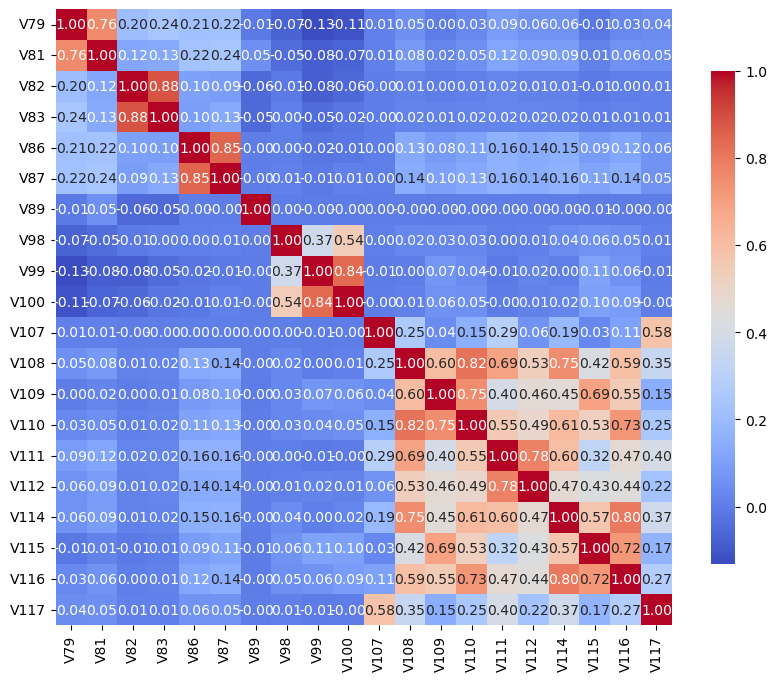

In [16]:
plot_corr(df_train.iloc[:,100:120])

In [17]:
len(df_train.columns)

142